In [1]:
import time
ini=time.time()

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

imp_fert=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_quanti.csv')
exp_soja=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/exp_soja_ncm_quanti.csv')

comex=pd.concat([imp_fert,exp_soja]).sort_values(by=['year','month'])\
.drop(columns=['US$_freight','US$_insurance','cif_kg','fob_kg','preço'])

imp_fert=exp_soja=0

# Save real begins and ends
comex['date']=pd.to_datetime(comex.year.astype(str)+'-'+comex.month.astype(str)+'-01')
date_min=comex.date.min()
date_max=comex.date.max()

# filtra km deixando passar o maior km de cada produto
filtra_km=comex[['Product','km']].drop_duplicates().sort_values(by=['Product','km'],ascending=False)\
    .drop_duplicates(subset='Product')
comex=comex.merge(filtra_km)

comex=comex.groupby(by=['year','month','Product','UF'],observed=True)['kg'].sum().reset_index()
comex['date']=pd.to_datetime(comex.year.astype(str)+'-'+comex.month.astype(str)+'-01')

In [2]:
# hipotesys to test
hip_list = ['lonely','conj']

# General parameters
years_rept=15
prdt_foco='MOP'
uf_foco='BA'
month_foco=(comex.date.max()+DateOffset(months=1)).month

# Parameters for lonely processing
prdt_lonely=[prdt_foco]
uf_lonely=[uf_foco]
month_lonely=[month_foco]
degree=1

# Parameters for joint processing
prdt_conj=[prdt_foco]+['MAP','Soy Group']
uf_conj=[uf_foco]+['GO']
m_ext=3
m_ini=month_foco-m_ext
month_conj=np.arange(m_ini,month_foco+1)
month_conj[month_conj<=0]+=12
max_depth=None
max_features=None

# Dict for tests
dict={'lonely':[prdt_lonely, uf_lonely, month_lonely],
      'conj'  :[prdt_conj  , uf_conj,   month_conj]}

In [3]:
# Calendar full
years=pd.DataFrame({'year':np.arange(date_min.year, date_max.year+1)}).assign(key=0)
months=pd.DataFrame({'month':np.arange(1,13)}).assign(key=0)
calendar=years.merge(months,on='key')
calendar_full=comex[['Product','UF']].drop_duplicates().assign(key=0).merge(calendar,on='key').drop('key',axis=1)

# Comex merge calendar full
comex_full=comex.merge(calendar_full,how='outer')

# Saprse Matrix
comex_full[['month','Product','UF']]=comex_full[['month', 'Product','UF']].astype(str)
comex_sprs=comex_full.groupby(by=['year','month','Product','UF'],observed=False)['kg'].sum().reset_index()

# Prune
comex_sprs['date']=pd.to_datetime(comex_sprs.year.astype(str)+'-'+comex_sprs.month.astype(str)+'-01')
comex_sprs=comex_sprs[(comex_sprs.date>=date_min)&(comex_sprs.date<=date_max)]

In [4]:
# Df for tests
date_max_test=comex_sprs.date.max()-DateOffset(months=11)
cst=comex_sprs_tests=comex_sprs[comex_sprs.date<=date_max_test]

# TESTS

results=pd.DataFrame()

for f in hip_list:

    h=dict[f]

    # Filtra Product, UF and month
    '''This filtering process is been doing here because in the 'conj' hypotesy, the features should be more than the focos features'''
    comex_t1=comex_sprs_tests[
    (comex_sprs_tests.Product.isin(h[0]))&
    (comex_sprs_tests.UF.isin(h[1]))&
    (comex_sprs_tests.month.astype(int).isin(h[2]))].copy()

    # Dummies
    comex_t1=pd.get_dummies(comex_t1,prefix_sep='~')

    # Indentify occurances
    comex_t1=comex_t1.assign(oc=0)
    comex_t1.loc[comex_t1.kg>0,'oc']=1

    # At the end of each repetirion, the last one will be droped,desrtoing comex_t2 for reuse. 
    # Then, here it will be remade for each hipotesys
    comex_t2=comex_t1.copy()
    

    # Repetitions of the test troughout the years
    for r in range(1,years_rept+1):
        
        # Classifying
        train=comex_t2[comex_t2.date<comex_t2.date.max()]
        test=comex_t2[comex_t2.date==comex_t2.date.max()]

        train.date=train.date.astype(int)
        test.date=test.date.astype(int)
    
        X_train=train.drop(['kg','oc'],axis=1)
        
        y_train=train.oc
        X_test=test.drop(['kg','oc'],axis=1)
        
        y_test=test.oc
        
        from sklearn.ensemble import RandomForestClassifier as rfc
        
        model=rfc()

        model.fit(X_train,y_train)

        test['oc_pred']=model.predict(X_test)

        test.date=test.date.astype('datetime64[ns]')
        
        if r==1:
            result_class=test
        else:
            result_class=pd.concat([result_class,test])


        comex_t2=comex_t2[comex_t2.date<=comex_t2.date.max()-DateOffset(years=1)]

    # Regression
    
    comex_t1=result_class.merge(comex_t1,how='outer')
        
    comex_t1=comex_t1[(comex_t1.oc==1)&(comex_t1.oc_pred.isin([1,np.nan]))].drop(columns=['oc','oc_pred'])

    comex_t2=comex_t1.copy()
    
    for r in range(1,years_rept+1):
        
        train=comex_t2[comex_t2.date<comex_t2.date.max()]
        test=comex_t2[comex_t2.date==comex_t2.date.max()]

        train.date=train.date.astype(int)
        test.date=test.date.astype(int)
    
          
        if f == 'conj':
            from sklearn.ensemble import RandomForestRegressor as model
            model=model(max_depth=max_depth,max_features=max_features)
        else:
            from sklearn.linear_model import LinearRegression
            from sklearn.preprocessing import PolynomialFeatures
            from sklearn.pipeline import make_pipeline
            polynomial_features = PolynomialFeatures(degree=degree)
            linear_regression = LinearRegression()
            model = make_pipeline(polynomial_features, linear_regression)

            

        X_train=train.drop(['kg'],axis=1)
        y_train=train.kg
        
        X_test=test.drop(['kg'],axis=1)
        y_test=test.kg

        model.fit(X_train,y_train)
        test['kg_pred']=model.predict(X_test)

        test.date=test.date.astype('datetime64[ns]')
        
        if r==1:
            result_regr=test
        else:
            result_regr=pd.concat([result_regr,test])

        result_class=result_class.assign(hyp_list=f)
        result_regr=  result_regr.assign(hyp_list=f)
                
        comex_t2=comex_t2[comex_t2.date<=comex_t2.date.max()-DateOffset(years=1)]

    result=result_class.merge(result_regr)



    
    print('\n',f)
    
    def Back_from_dummies(comex_dumm):
        o=comex_dumm[comex_dumm.columns[~comex_dumm.columns.str.contains('~')]]    
        prdt=pd.from_dummies(comex_dumm[comex_dumm.columns[comex_dumm.columns.str.contains('Product')]],sep='~')    
        month=pd.from_dummies(comex_dumm[comex_dumm.columns[comex_dumm.columns.str.contains('month')]],sep='~')    
        uf=pd.from_dummies(comex_dumm[comex_dumm.columns[comex_dumm.columns.str.contains('UF')]],sep='~')    
        comex_dumm=pd.concat([o,prdt,month,uf],axis=1)
        return comex_dumm

    result=Back_from_dummies(result)

    

    # Filtering
    mes=result.month.unique()[0]    
    result=result[(result.Product=='MOP')&(result.month==mes)&(result.UF=='BA')]

    # Metrics
    from sklearn.metrics import root_mean_squared_error as rse
    result['rse']=rse(result.kg,result.kg_pred)    
    print(f"\nPara {f} - rse = {int(result.rse.unique()/10**6)} Kton")

    results=pd.concat([result,results])
    

end=time.time()

print(f"Duração: {round((end-ini)/60,1)} minutos.")


 lonely

Para lonely - rse = 29 Kton

 conj

Para conj - rse = 23 Kton
Duração: 0.2 minutos.


In [5]:
results=results.sort_values('year')

In [6]:
# PREDIÇÃO

pred=pd.DataFrame()

for f in hip_list:

    
    h=dict[f]

    
    # Filtra Product, UF and month
    comex_t1=comex_sprs[
    (comex_sprs.Product.isin(h[0]))&
    (comex_sprs.UF.isin(h[1]))&
    (comex_sprs.month.astype(int).isin(h[2]))].copy()

    
    # Dummies
    comex_t1=pd.get_dummies(comex_t1,prefix_sep='~')
    
    # Identify occurances    
    comex_t1=comex_t1.assign(oc=0)
    comex_t1.loc[comex_t1.kg>0,'oc']=1
    
    # Classifying
    train=comex_t1.copy()
    
    X_pred=train.drop(columns=['kg','oc'])
    X_pred.date=comex_sprs.date.max()+DateOffset(months=1)


    
    X_pred.year=X_pred.date.dt.year
    X_pred.month=X_pred.date.dt.month
    X_pred[X_pred.columns[X_pred.columns.str.contains('~')]]=False
    X_pred['Product~'+prdt_foco]=True
    X_pred['month~'+str(month_foco)]=True
    X_pred['UF~'+str(uf_foco)]=True
    X_pred=X_pred.drop_duplicates()
        
    train.date=train.date.astype(int)
    X_pred.date=X_pred.date.astype(int)

    X_train=train.drop(['kg','oc'],axis=1)

    y_train_c=train.oc
    
    from sklearn.ensemble import RandomForestClassifier as rfc
    
    model=rfc()
    model.fit(X_train,y_train_c)
    X_pred['oc_pred']=model.predict(X_pred)

    # Regression
    
    if f == 'conj':
        from sklearn.ensemble import RandomForestRegressor as model
        model=model(max_depth=max_depth,max_features=max_features)
    else:
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.pipeline import make_pipeline
        polynomial_features = PolynomialFeatures(degree=degree)
        linear_regression = LinearRegression()
        model = make_pipeline(polynomial_features, linear_regression)

        

    y_train_r=train.kg
    
    X_pred=X_pred[X_pred.oc_pred==1].drop(columns='oc_pred')
    
    model.fit(X_train,y_train_r)
    
    X_pred['kg_pred']=model.predict(X_pred)

    X_pred=X_pred.assign(hyp_list=f)

    X_pred=Back_from_dummies(X_pred).assign(oc_pred=1)

    pred=pd.concat([pred,X_pred])

In [7]:
fim=pd.concat([results,pred])

fim.date=fim.date.astype('datetime64[ns]')

fim.month=fim.month.astype(int)

fim=fim.drop(columns='kg').merge(comex.merge(fim[['month','UF','Product']].drop_duplicates()),how='outer')

fim=fim.sort_values('year')

fim2=pd.concat([
    fim.drop(columns='kg_pred').assign(tipo='real'),
    fim[fim.hyp_list=='lonely'].drop(columns='kg').assign(tipo='pred_lonely').rename(columns={'kg_pred':'kg'}),
    fim[fim.hyp_list=='conj'].drop(columns='kg').assign(tipo='pred_conj').rename(columns={'kg_pred':'kg'})
])\
.sort_values('year')[['year','month','Product','UF','kg','tipo']].drop_duplicates().dropna()

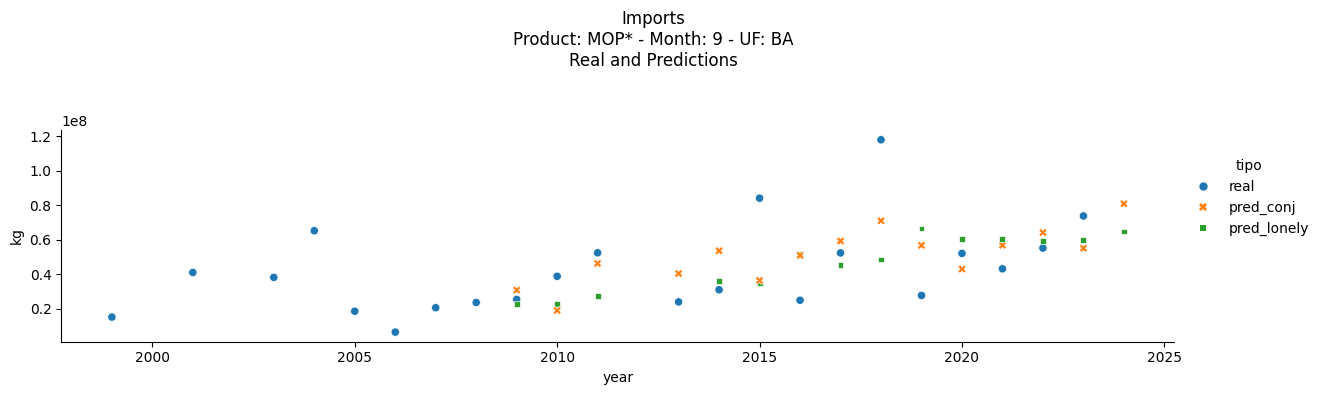

In [27]:
g=sns.relplot(data=fim2,x='year',y='kg',hue='tipo',style='tipo',height=3,aspect=4)

#g.set(ylim=(0, 1*10**8))
g.fig.suptitle(f"Imports\nProduct: MOP* - Month: {mes} - UF: BA\nReal and Predictions",y=1.3)
#plt.xticks(ticks=fim2.year.unique())


plt.show()

In [9]:
end=time.time()
print(f"Duração: {round((end-ini)/60,1)} minutos.")

Duração: 0.2 minutos.
